In [73]:
import pandas as pd

In [74]:
csv_path = '../../blocklearning-results/results/CURRENT/logs/report.csv'
df = pd.read_csv(csv_path, names=["round", "training_accuracy", "validation_accuracy"], dtype={'round': 'int', 'training_accuracy': 'float', 'validation_accuracy': 'float'})

/home/andras/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


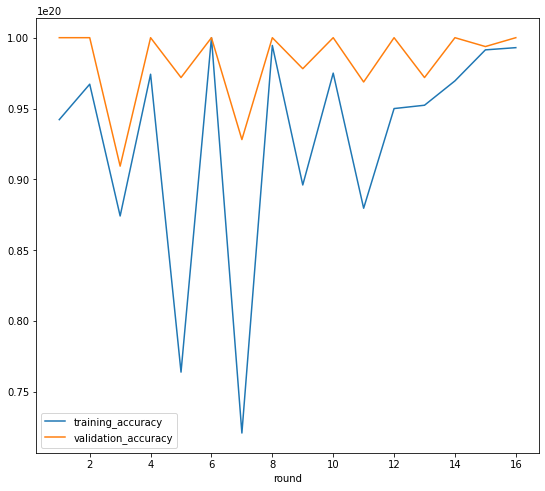

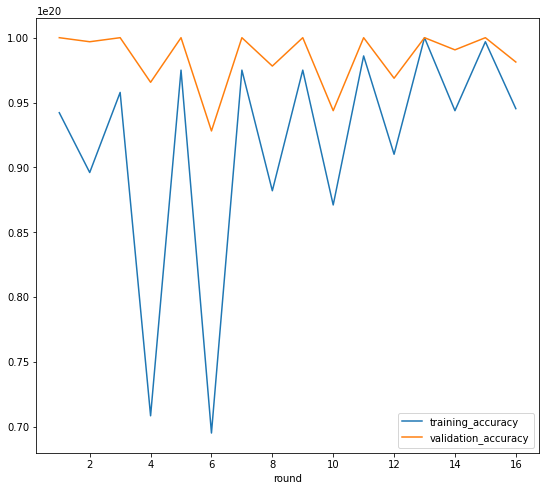

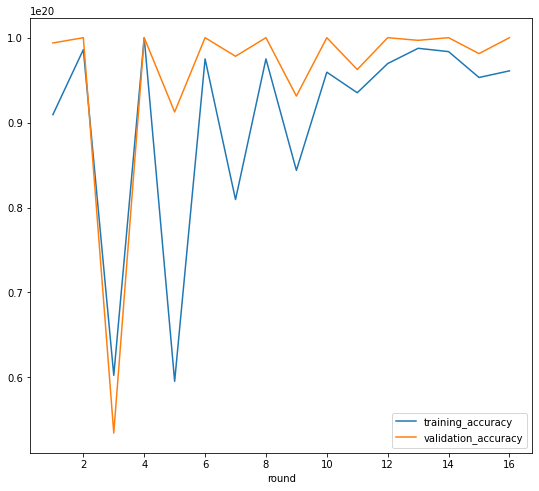

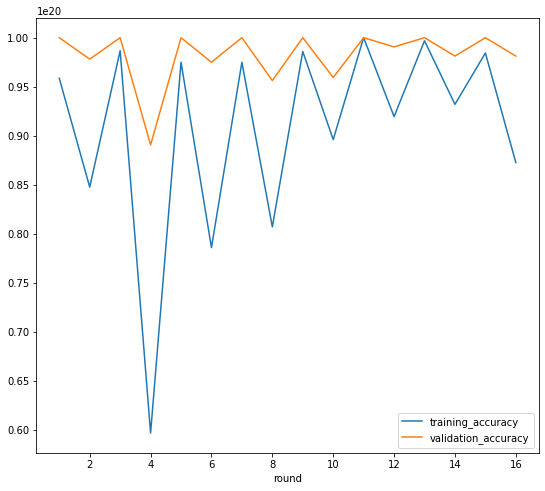

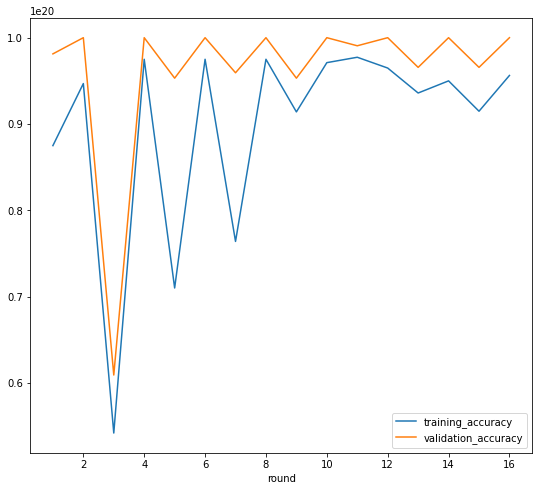

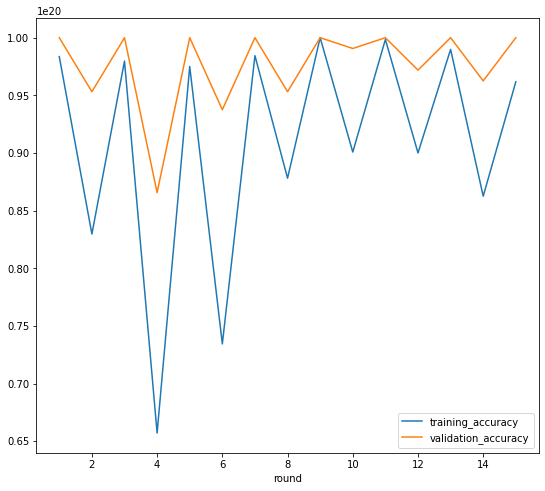

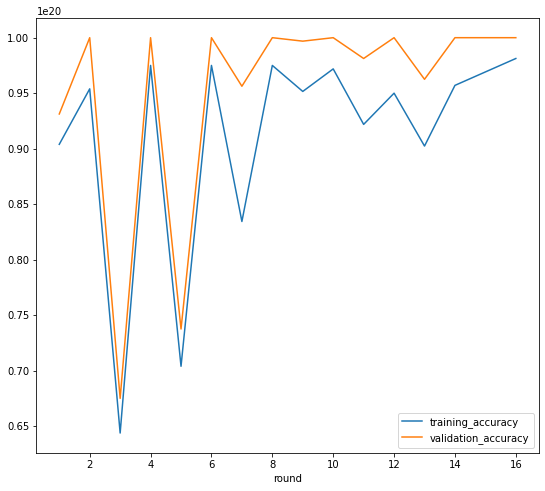

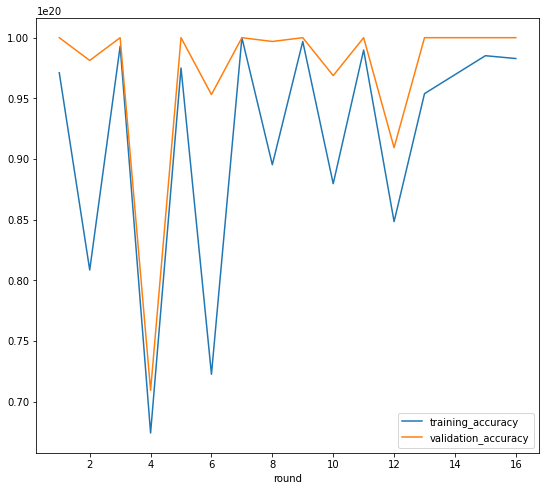

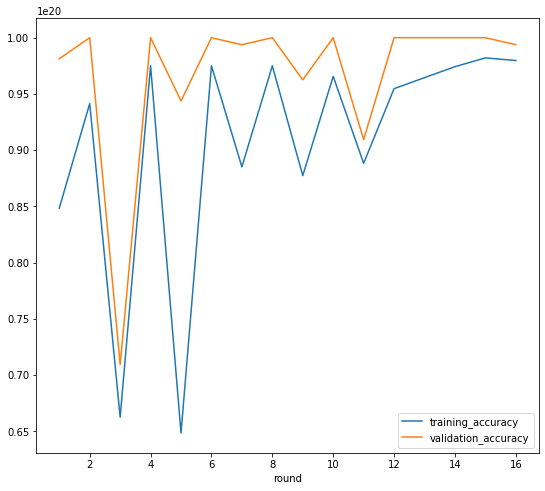

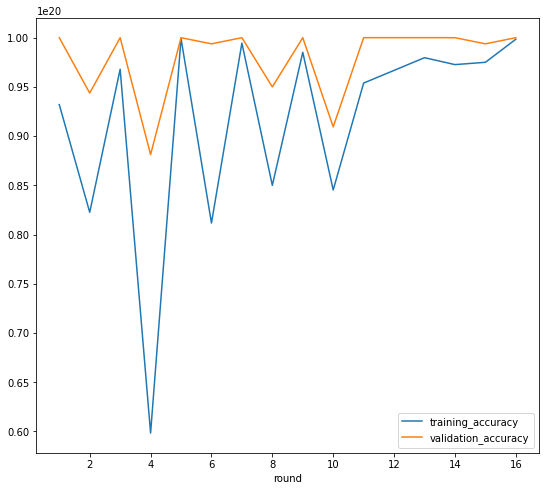

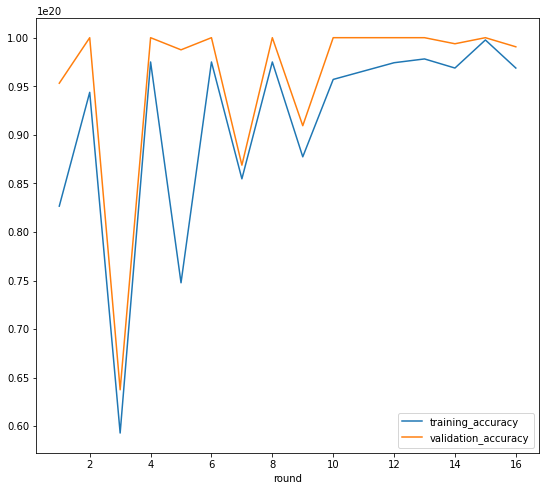

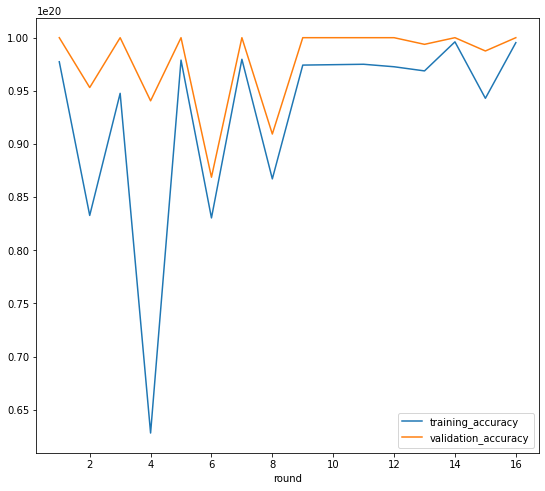

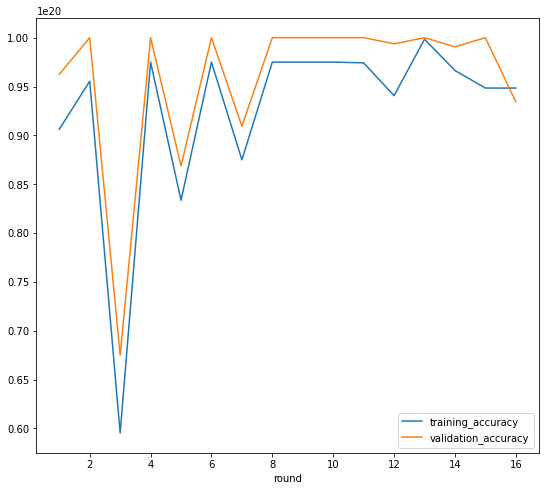

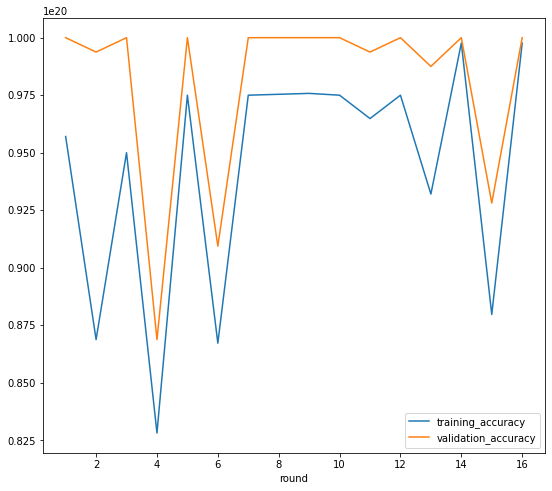

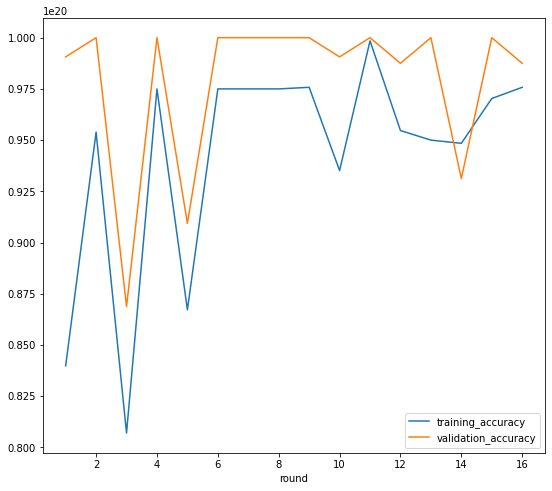

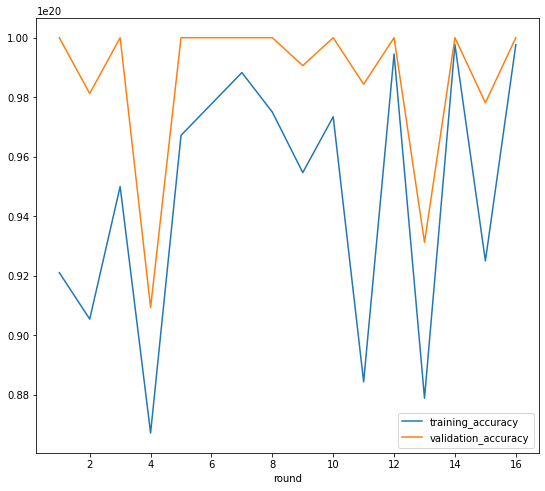

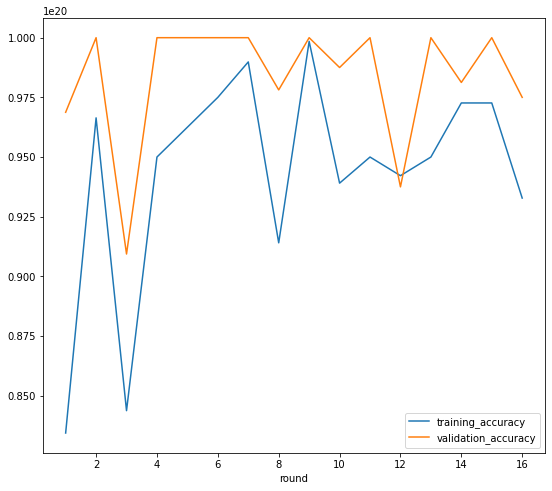

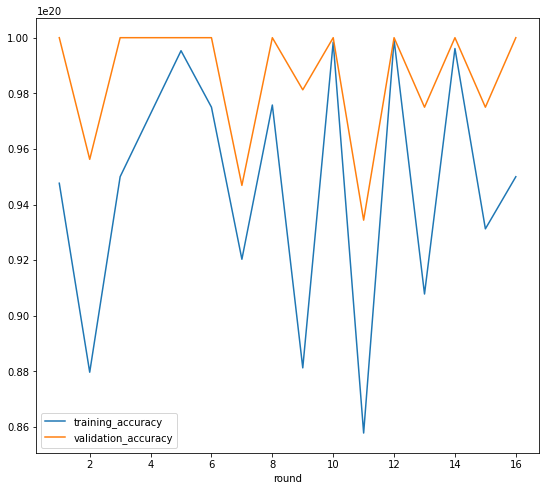

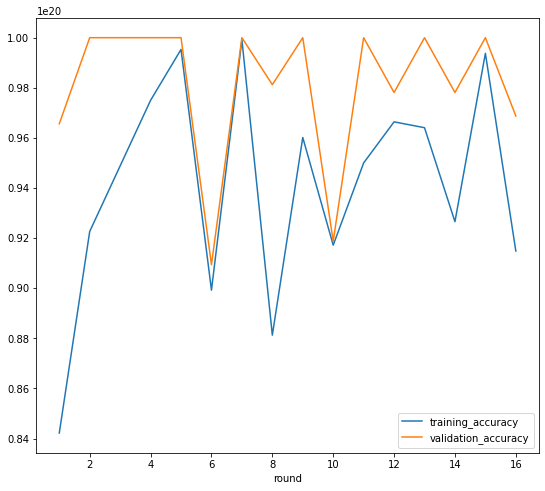

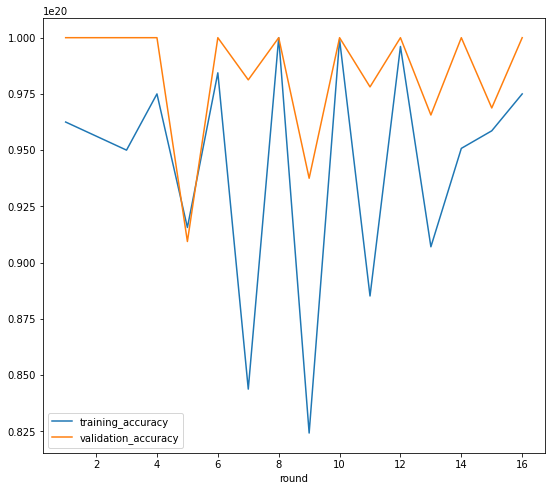

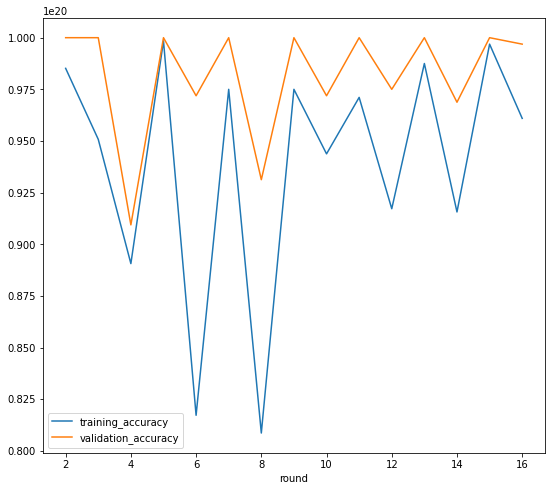

In [75]:
for i in range(21):
    df_rep = df.iloc[df.index % 21 == i]
    df_rep.plot(x="round", y=["training_accuracy", "validation_accuracy"], figsize=(9, 8))